In [16]:
# interactive figure
%matplotlib widget

In [1]:
# auto reload modules
%load_ext autoreload
%autoreload 2

import os
import warnings
import gcm_filters
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# import matplotlib.ticker as tkr
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap, CenteredNorm, BoundaryNorm
from sys import platform
from xgcm import Grid
from viztool import pcolor_center, pcolor_lim
from spectrum import Gaussian_filter_2d
from spectrum import TWODimensional_spec

In [2]:
if platform == 'linux' or platform == 'linux2':
    data_dir = '/glade/derecho/scratch/zhihuaz/TracerInversion/Output/'
elif platform == 'darwin':
    data_dir = '/Users/zhihua/Documents/Work/Research/Projects/TRACE-SEAS/TracerInversion/Data/'
else:
    print('OS not supported.')

#### Subset data for local analysis

In [24]:
# cname = 'd11_M003_Ri020_em01_Q001_W000_D000_St0'
# cname = 'd11_M003_Ri040_em01_Q001_W000_D000_St0'
cname = 'd11_M003_Ri040_em01_Q010_W000_D000_St0'
# ds = xr.open_dataset(data_dir+cname+'_state.nc', decode_timedelta=True).isel(time=-1, zC=[28, 46, 58, -1]).chunk(zC=1)
ds = xr.open_dataset(data_dir+cname+'_state.nc', decode_timedelta=True).isel(time=-1, zC=slice(20,None), zF=slice(20,None)).chunk('auto')
ds.close()

varlist = ['u', 'v', 'w', 'b', 'c7', 'xF', 'yF', 'zF']
ds = ds[varlist]

from dask.diagnostics import ProgressBar
delayed_nc = ds.to_netcdf(data_dir + cname + '_last.nc', compute=False)
with ProgressBar():
    results = delayed_nc.compute(num_workers=2, threads_per_worker=2, memory_limit='2GB', processes=False)

[########################################] | 100% Completed | 17.35 s


#### Load data

In [3]:
# cname = 'd11_M003_Ri020_em01_Q010_W000_D000_St0'
# cname = 'd11_M003_Ri020_em01_Q001_W000_D000_St0'

# cname = 'd11_M003_Ri040_em03_Q001_W000_D000_St0'
cname = 'd11_M003_Ri040_em01_Q010_W000_D000_St0'
ds = xr.open_dataset(data_dir+cname+'_state.nc', decode_timedelta=True).isel(time=-1, zC=[46, 58, -1])#.chunk(zC=1)
# ds = xr.open_dataset(data_dir+cname+'_state.nc', decode_timedelta=True).isel(time=-1, zC=[28, 46, 58, -1])#.chunk(zC=1)
# ds = xr.open_dataset(data_dir+cname+'_state.nc', decode_timedelta=True).isel(time=[24*3*2-1, 24*3*3-1, 24*3*4-1], zC=[46, 58])#.chunk(zC=1)

ds.close()
ds['day'] = ds.time/np.timedelta64(1, 'D')
ds

<xarray.Dataset> Size: 264MB
Dimensions:  (zC: 3, yC: 1000, xC: 2000, zF: 65, yF: 1000, xF: 2000)
Coordinates:
  * zC       (zC) float32 12B -29.72 -9.341 -0.8492
  * zF       (zF) float32 260B -150.0 -135.6 -125.1 -117.3 ... -3.397 -1.698 0.0
  * xC       (xC) float32 8kB -3.998e+03 -3.994e+03 ... 3.994e+03 3.998e+03
  * yF       (yF) float32 4kB 0.0 4.0 8.0 12.0 ... 3.988e+03 3.992e+03 3.996e+03
  * xF       (xF) float32 8kB -4e+03 -3.996e+03 ... 3.992e+03 3.996e+03
  * yC       (yC) float32 4kB 2.0 6.0 10.0 14.0 ... 3.99e+03 3.994e+03 3.998e+03
    time     timedelta64[ns] 8B 9 days
Data variables:
    c1       (zC, yC, xC) float32 24MB ...
    b        (zC, yC, xC) float32 24MB ...
    v        (zC, yC, xC) float32 24MB ...
    c2       (zC, yC, xC) float32 24MB ...
    w        (zC, yC, xC) float32 24MB ...
    c4       (zC, yC, xC) float32 24MB ...
    c6       (zC, yC, xC) float32 24MB ...
    c3       (zC, yC, xC) float32 24MB ...
    c7       (zC, yC, xC) float32 24MB ...
    u        (zC, yC, xC) float32 24MB ...
    c5       (zC, yC, xC) float32 24MB ...
    day      float64 8B 9.0
Attributes: (12/73)
    Ly:                     4000.0
    use_Stokes:             0
    n_per_set:              3.0
    save_ckp_interval:      86400.0
    ϵv:                     0.0018
    Hm:                     60.0
    ...                     ...
    τ₀ʸ:                    0.0
    tracer_reset_interval:  1
    Ny:                     1000
    Oceananigans:           This file was generated using Oceananigans v0.95.12
    RiB₁:                   40.0
    σ_wind:                 0

In [4]:
filter_taper = gcm_filters.Filter(
    filter_scale=300,
    dx_min=4,
    filter_shape=gcm_filters.FilterShape.TAPER,
    # transition_width=np.pi,
    grid_type=gcm_filters.GridType.REGULAR,
)
dsl = filter_taper.apply(ds, dims=['yC', 'xC'])
# %time dsl.compute();
dsh = ds - dsl
ds['xC'] = ds.xC/1e3
ds['yC'] = ds.yC/1e3
dsl['xC'] = dsl.xC/1e3
dsl['yC'] = dsl.yC/1e3
dsh['xC'] = dsh.xC/1e3
dsh['yC'] = dsh.yC/1e3
dsh

<xarray.Dataset> Size: 528MB
Dimensions:  (zC: 3, zF: 65, xC: 2000, yF: 1000, xF: 2000, yC: 1000)
Coordinates:
  * zC       (zC) float32 12B -29.72 -9.341 -0.8492
  * zF       (zF) float32 260B -150.0 -135.6 -125.1 -117.3 ... -3.397 -1.698 0.0
  * xC       (xC) float32 8kB -3.998 -3.994 -3.99 -3.986 ... 3.99 3.994 3.998
  * yF       (yF) float32 4kB 0.0 4.0 8.0 12.0 ... 3.988e+03 3.992e+03 3.996e+03
  * xF       (xF) float32 8kB -4e+03 -3.996e+03 ... 3.992e+03 3.996e+03
  * yC       (yC) float32 4kB 0.002 0.006 0.01 0.014 ... 3.986 3.99 3.994 3.998
    time     timedelta64[ns] 8B 9 days
Data variables:
    c1       (zC, yC, xC) float64 48MB -0.001332 -0.001305 ... -0.001553
    b        (zC, yC, xC) float64 48MB 1.025e-06 8.362e-07 ... 1.129e-06
    v        (zC, yC, xC) float64 48MB -0.002472 -0.003104 ... -0.0004002
    c2       (zC, yC, xC) float64 48MB -0.002475 -0.0002626 ... 0.01135 0.01547
    w        (zC, yC, xC) float64 48MB 0.006312 0.006192 ... 0.0002148 0.0005738
    c4       (zC, yC, xC) float64 48MB 0.002072 0.0003718 ... -0.008398 -0.01147
    c6       (zC, yC, xC) float64 48MB -0.0007511 0.0007587 ... 0.009238 0.01184
    c3       (zC, yC, xC) float64 48MB 0.004961 0.004835 ... 0.006409 0.005861
    c7       (zC, yC, xC) float64 48MB -0.001462 0.0001808 ... 0.009117 0.01215
    u        (zC, yC, xC) float64 48MB -0.0001694 0.0001239 ... -0.0007569
    c5       (zC, yC, xC) float64 48MB -0.01003 -0.009751 ... -0.01328 -0.01207
    day      float64 8B 0.0

In [5]:
periodic_coords = {dim : dict(left=f'{dim}F', center=f'{dim}C') for dim in 'xy'}
bounded_coords = {dim : dict(outer=f'{dim}F', center=f'{dim}C') for dim in 'z'}
coords = {dim : periodic_coords[dim] if tpl=='P' else bounded_coords[dim] for dim, tpl in zip('xyz', 'PPN')}
grid = Grid(ds, coords=coords)
dxF = ds.xF.diff('xF').data[0]
dyF = ds.yF.diff('yF').data[0]
# dzF = ds.zF.diff('zF').data

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    b_xf = grid.interp(ds.b, axis='x').transpose(..., 'xF')
    b_yf = grid.interp(ds.b, axis='y').transpose(..., 'yF')
    # b_zf = grid.interp(ds.b, axis='z', boundary='extend').transpose(..., 'zF')
    u_xf = grid.interp(ds.u, axis='x').transpose(..., 'xF')
    u_yf = grid.interp(ds.u, axis='y').transpose(..., 'yF')
    # u_zf = grid.interp(ds.u, axis='z', boundary='extend').transpose(..., 'zF')
    v_xf = grid.interp(ds.v, axis='x').transpose(..., 'xF')
    v_yf = grid.interp(ds.v, axis='y').transpose(..., 'yF')
    # v_zf = grid.interp(ds.v, axis='z', boundary='extend').transpose(..., 'zF')
    
    ds['dbdx'] = grid.diff(b_xf, axis='x') / dxF
    ds['dbdy'] = grid.diff(b_yf, axis='y') / dyF
    # ds['dbdz'] = grid.diff(b_zf, axis='z') / dzF
    
    ds['dudx'] = grid.diff(u_xf, axis='x') / dxF
    ds['dudy'] = grid.diff(u_yf, axis='y') / dyF
    # ds['dudz'] = grid.diff(u_zf, axis='z') / dzF

    ds['dvdx'] = grid.diff(v_xf, axis='x') / dxF
    ds['dvdy'] = grid.diff(v_yf, axis='y') / dyF
    # ds['dvdz'] = grid.diff(v_zf, axis='z') / dzF

ds['ζ'] = ds.dvdx - ds.dudy
ds['δ'] = ds.dudx + ds.dvdy
ds['σₛ'] = ds.dvdx + ds.dudy
ds['σₙ'] = ds.dudx - ds.dvdy
ds['σ'] = np.sqrt(ds['σₛ']**2 + ds['σₙ']**2)
ds['M²'] = np.sqrt(ds['dbdx']**2 + ds['dbdy']**2)
# ds['Sh'] = np.sqrt(ds['dudz']**2 + ds['dvdz']**2)

In [6]:
dsl['xF'] = ds.xF
dsl['yF'] = ds.yF
dsl['zF'] = ds.zF
grid = Grid(dsl, coords=coords)
dxF = dsl.xF.diff('xF').data[0]
dyF = dsl.yF.diff('yF').data[0]
# dzF = dsl.zF.diff('zF').data

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    b_xf = grid.interp(dsl.b, axis='x').transpose(..., 'xF')
    b_yf = grid.interp(dsl.b, axis='y').transpose(..., 'yF')
    # b_zf = grid.interp(dsl.b, axis='z', boundary='extend').transpose(..., 'zF')
    u_xf = grid.interp(dsl.u, axis='x').transpose(..., 'xF')
    u_yf = grid.interp(dsl.u, axis='y').transpose(..., 'yF')
    # u_zf = grid.interp(dsl.u, axis='z', boundary='extend').transpose(..., 'zF')
    v_xf = grid.interp(dsl.v, axis='x').transpose(..., 'xF')
    v_yf = grid.interp(dsl.v, axis='y').transpose(..., 'yF')
    # v_zf = grid.interp(dsl.v, axis='z', boundary='extend').transpose(..., 'zF')
    
    dsl['dbdx'] = grid.diff(b_xf, axis='x') / dxF
    dsl['dbdy'] = grid.diff(b_yf, axis='y') / dyF
    # dsl['dbdz'] = grid.diff(b_zf, axis='z') / dzF
    
    dsl['dudx'] = grid.diff(u_xf, axis='x') / dxF
    dsl['dudy'] = grid.diff(u_yf, axis='y') / dyF
    # dsl['dudz'] = grid.diff(u_zf, axis='z') / dzF

    dsl['dvdx'] = grid.diff(v_xf, axis='x') / dxF
    dsl['dvdy'] = grid.diff(v_yf, axis='y') / dyF
    # dsl['dvdz'] = grid.diff(v_zf, axis='z') / dzF

dsl['ζ'] = dsl.dvdx - dsl.dudy
dsl['δ'] = dsl.dudx + dsl.dvdy
dsl['σₛ'] = dsl.dvdx + dsl.dudy
dsl['σₙ'] = dsl.dudx - dsl.dvdy
dsl['σ'] = np.sqrt(dsl['σₛ']**2 + dsl['σₙ']**2)
dsl['M²'] = np.sqrt(dsl['dbdx']**2 + dsl['dbdy']**2)
# dsl['Sh'] = np.sqrt(dsl['dudz']**2 + dsl['dvdz']**2)

#### Visualize sliced fields

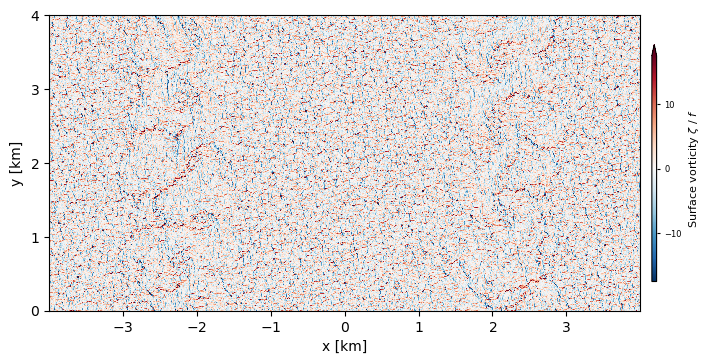

In [22]:
plt.close()
plt.figure(figsize=(7, 3.5), constrained_layout=True)
# plt.figure(figsize=(7, 3.5), dpi=400, constrained_layout=True)

iz = -1

# pcm,_ = pcolor_center(ds.w.isel(zC=iz), plt.gca(), cmap='RdBu_r')
# pcm = pcolor_lim(ds.c7.isel(zC=iz).load(), plt.gca(), cmap='turbo')
# pcm = pcolor_lim(ds.b.isel(zC=iz).load(), plt.gca(), cmap='Spectral_r')
# pcm,_ = pcolor_center(ds['Sh'].isel(zC=iz), plt.gca(), cmap='RdBu_r')#, sym_mag=6)

# pcm = pcolor_lim(np.abs(ds['w'].isel(zC=iz)), plt.gca(), cmap='binary', clim=[0,3.3e-3])
# colorlist = ['xkcd:cerulean', 'xkcd:very light blue', 'xkcd:white', 'xkcd:light rose', 'xkcd:red']
# nodes = [0.0, 0.35, 0.5, 0.65, 1.0]
# cmapw = LinearSegmentedColormap.from_list('w', list(zip(nodes, colorlist)))
# pcm,_ = pcolor_center(ds['w'].isel(zC=iz).where(ds['w'].isel(zC=iz)<0), plt.gca(), cmap=cmapw, sym_mag=3.3e-3)
# pcm = pcolor_lim(np.abs(ds['w'].isel(zC=iz)), plt.gca(), cmap='binary', clim=[0, 3.3e-3])
# cbar = plt.colorbar(pcm, ax=plt.gca(), location='right', shrink=0.8, aspect=50, pad=0.02, extend='min')

# pcm = pcolor_lim(ds['M²'].isel(zC=iz)/ds.attrs['M²'], plt.gca(), cmap='Purples')#, clim=[0, 5])
# plt.contour(ds.xC, ds.yC, ds['M²'].isel(zC=iz)/ds.attrs['M²'], 8, colors='gray', linewidths=0.5)
# pcm,_ = pcolor_center(ds['ζ'].isel(zC=iz)/ds.f, plt.gca(), cmap='RdBu_r', sym_mag=10)
# pcm,_ = pcolor_center(ds['δ'].isel(zC=iz)/ds.f, plt.gca(), cmap='RdBu_r')#, sym_mag=10)
pcm,_ = pcolor_center(ds['σₙ'].isel(zC=iz)/ds.f, plt.gca(), cmap='RdBu_r')#, sym_mag=10)
# pcm = pcolor_lim(ds['σ'].isel(zC=iz)/ds.f, plt.gca(), cmap='Reds')#, clim=[0, 10])
cbar = plt.colorbar(pcm, ax=plt.gca(), location='right', shrink=0.8, aspect=50, pad=0.02, extend='max')

cbar.ax.tick_params(labelsize=6, length=2)
# cbar.ax.locator_params(nbins=7)
cbar.ax.locator_params(nbins=6)
# cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set_fontsize(6)
cbar.ax.yaxis.get_offset_text().set_position((4, 0.8))

# cbar.set_label(label=r'Surface $b$ [m s$^{-2}$]', size=8)
# cbar.set_label(label=r'$w$ @ 10 m depth [m s$^{-1}$]', size=8)
# cbar.set_label(label=r'$M^2$ / $M_0^2$ @ 10 m depth', size=8)
# cbar.set_label(label=r'Surface strain $\sigma$ / $f$', size=8)
# cbar.set_label(label=r'Surface divergence $\delta$ / $f$', size=8)
cbar.set_label(label=r'Surface vorticity $\zeta$ / $f$', size=8)
plt.gca().set_aspect('equal')
plt.gca().set_yticks(np.linspace(0,4,5))
plt.xlabel('x [km]')
plt.ylabel('y [km]');
# plt.xlim(0.5, 1.5)
# plt.ylim(1.9, 2.9);

#### Visualize sliced coarse-grained fields

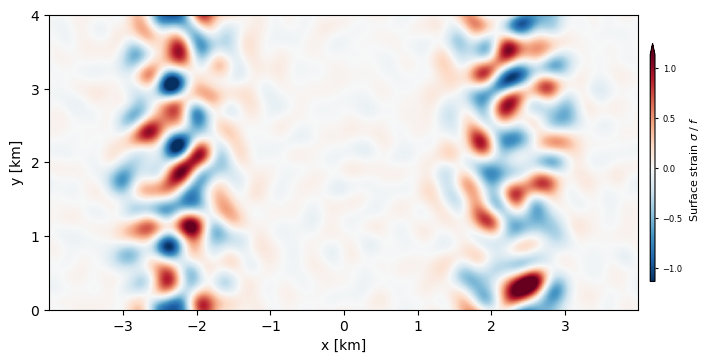

In [20]:
plt.close()
plt.figure(figsize=(7, 3.5), constrained_layout=True)
# plt.figure(figsize=(7, 3.5), dpi=400, constrained_layout=True)

iz = -1

# pcm,_ = pcolor_center(dsl.u.isel(zC=iz), plt.gca(), cmap='RdBu_r')
# pcm,_ = pcolor_center(dsh.c7.isel(zC=iz).where(dsl['M²'].isel(zC=iz)/dsl.attrs['M²'] < 0.01), plt.gca(), cmap='RdBu_r', sym_mag=2e-2)
# pcm = pcolor_lim(dsl.b.isel(zC=iz), plt.gca(), cmap='Spectral_r')
# pcm,_ = pcolor_center(dsl['Sh'].isel(zC=iz), plt.gca(), cmap='RdBu_r')#, sym_mag=6)

# pcm = pcolor_lim(np.abs(dsl['w'].isel(zC=iz)), plt.gca(), cmap='binary', clim=[0,3.3e-4])
# colorlist = ['xkcd:cerulean', 'xkcd:very light blue', 'xkcd:white', 'xkcd:light rose', 'xkcd:red']
# nodes = [0.0, 0.35, 0.5, 0.65, 1.0]
# cmapw = LinearSegmentedColormap.from_list('w', list(zip(nodes, colorlist)))
# pcm,_ = pcolor_center(dsh['w'].isel(zC=iz), plt.gca(), cmap=cmapw, sym_mag=3.3e-3)
# pcm,_ = pcolor_center(dsh['w'].isel(zC=iz).where(dsh['w'].isel(zC=iz)<0), plt.gca(), cmap=cmapw, sym_mag=3.3e-4)
# pcm = pcolor_lim(np.abs(dsh['w'].isel(zC=iz)), plt.gca(), cmap='binary', clim=[0, 3.3e-3])
# cbar = plt.colorbar(pcm, ax=plt.gca(), location='right', shrink=0.8, aspect=50, pad=0.02, extend='min')

# pcm = pcolor_lim(dsl['M²'].isel(zC=iz)/dsl.attrs['M²'], plt.gca(), cmap='Purples')#, clim=[0, 5])
# plt.contour(dsl.xC, dsl.yC, dsl['M²'].isel(zC=iz)/dsl.attrs['M²'], [0.05], colors='c', linewidths=1)
# plt.contour(dsl.xC, dsl.yC, dsl['M²'].isel(zC=iz)/dsl.attrs['M²'], [0.2], colors='green', linewidths=0.5)

# pcm,_ = pcolor_center(dsl['ζ'].isel(zC=iz)/dsl.f, plt.gca(), cmap='RdBu_r')#, sym_mag=10)
# pcm,_ = pcolor_center(dsl['δ'].isel(zC=iz)/dsl.f, plt.gca(), cmap='RdBu_r')#, sym_mag=10)
pcm,_ = pcolor_center(dsl['σₙ'].isel(zC=iz)/dsl.f, plt.gca(), cmap='RdBu_r')#, sym_mag=10)
# pcm = pcolor_lim(dsl['σ'].isel(zC=iz)/dsl.f, plt.gca(), cmap='Reds')#, clim=[0, 10])
cbar = plt.colorbar(pcm, ax=plt.gca(), location='right', shrink=0.8, aspect=50, pad=0.02, extend='max')

cbar.ax.tick_params(labelsize=6, length=2)
# cbar.ax.locator_params(nbins=7)
# cbar.ax.locator_params(nbins=6)
# cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set_fontsize(6)
cbar.ax.yaxis.get_offset_text().set_position((4, 0.8))

# cbar.set_label(label=r'$w$ @ 10 m depth [m s$^{-1}$]', size=8)
# cbar.set_label(label=r'$M^2$ / $M_0^2$ @ 10 m depth', size=8)
cbar.set_label(label=r'Surface strain $\sigma$ / $f$', size=8)
# cbar.set_label(label=r'Surface divergence $\delta$ / $f$', size=8)
# cbar.set_label(label=r'Surface vorticity $\zeta$ / $f$', size=8)
plt.gca().set_aspect('equal')
plt.gca().set_yticks(np.linspace(0,4,5))
plt.xlabel('x [km]')
plt.ylabel('y [km]');
# plt.xlim(0.5, 1.5)
# plt.ylim(1.9, 2.9);

In [18]:
u_afm = ds.u.mean('yC')
v_afm = ds.v.mean('yC')
w_afm = ds.w.mean('yC')
b_afm = ds.b.mean('yC')
up = ds.u - u_afm
vp = ds.v - v_afm
wp = ds.w - w_afm
bp = ds.b - b_afm
upbp = up * bp
vpbp = vp * bp
wpbp = wp * bp

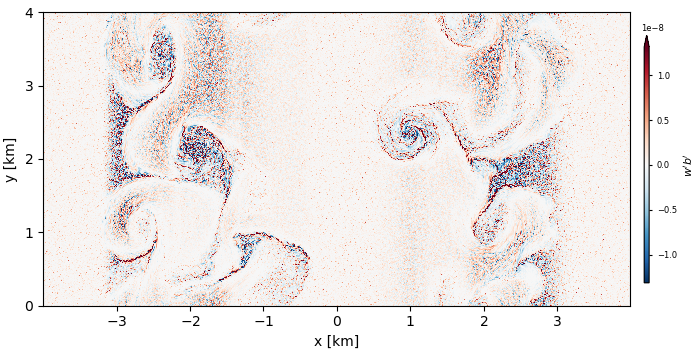

In [20]:
plt.close()
plt.figure(figsize=(7, 3.5), constrained_layout=True)
# plt.figure(figsize=(7, 3.5), dpi=400, constrained_layout=True)

# pcm = pcolor_lim(ds['M²'].isel(zC=-4)/ds.f**2, plt.gca(), cmap='Reds')
# pcm,_ = pcolor_center(ds['ζ'].isel(zC=-3)/ds.f, plt.gca(), cmap='RdBu_r')#, sym_mag=10)
# pcm,_ = pcolor_center(ds['δ'].isel(zC=-2)/ds.f, plt.gca(), cmap='RdBu_r')#, sym_mag=10)
pcm,_ = pcolor_center(wpbp.isel(zC=-2), plt.gca())#, sym_mag=5e-9)
cbar = plt.colorbar(pcm, ax=plt.gca(), location='right', shrink=0.8, aspect=50, pad=0.02, extend='max')

cbar.ax.tick_params(labelsize=6, length=2)
# cbar.ax.locator_params(nbins=7)
cbar.ax.locator_params(nbins=6)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set_fontsize(6)
cbar.ax.yaxis.get_offset_text().set_position((4, 0.8))

cbar.set_label(label=r"$w'b'$", size=8)
# cbar.set_label(label=r'Surface vorticity $\zeta$ / $f$', size=8)
plt.gca().set_aspect('equal')
plt.gca().set_yticks(np.linspace(0,4,5))
plt.xlabel('x [km]')
plt.ylabel('y [km]');
# plt.xlim(0.5, 1.5)
# plt.ylim(1.9, 2.9);

In [ ]:
plt.close()
plt.figure(figsize=(10, 2.8), constrained_layout=True)
blines = np.arange(0.97, 1.77, 0.04)*1e-4

# pcm,_ = pcolor_center(ds.w.sel(yC=3, method='nearest'), plt.gca(), cmap=cmapw, sym_mag=4e-3)
pcm = pcolor_lim(np.log10(ds.c7.sel(yC=3, method='nearest').clip(1e-3,1)), plt.gca(), cmap='turbo', clim=[-3,0])
# pcm = pcolor_lim(ds['σ'].sel(yC=3, method='nearest')/ds.f, plt.gca(), cmap='Reds', clim=[0,10])
# pcm,_ = pcolor_center(ds['ζ'].sel(yC=3, method='nearest')/ds.f, plt.gca(), sym_mag=5)
# pcm,_ = pcolor_center(ds.c7.sel(yC=3, method='nearest').load(), plt.gca())
plt.contour(ds.xC, ds.zC, ds.b.sel(yC=3, method='nearest').load(), levels=blines, colors='gray', linewidths=0.5)
plt.ylim(-75, 0);

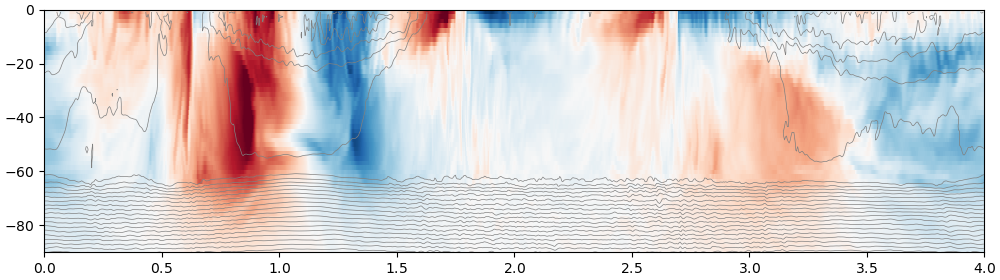

In [56]:
plt.close()
plt.figure(figsize=(10, 2.8), constrained_layout=True)
blines = np.arange(0.97, 1.77, 0.03)*1e-4

# pcm,_ = pcolor_center(ds.w.sel(xC=-2.8, method='nearest'), plt.gca(), cmap=cmapw, sym_mag=4e-3)
# pcm = pcolor_lim(ds.c7.sel(xC=-3, method='nearest'), plt.gca(), cmap='turbo', clim=[0,1])
pcm,_ = pcolor_center(ds.u.sel(xC=-2.8, method='nearest'), plt.gca())
plt.contour(ds.yC, ds.zC, ds.b.sel(xC=-3, method='nearest'), levels=blines, colors='gray', linewidths=0.5)
plt.ylim(-90, 0);

#### Joint probability density function (JPDF) of surface vorticity and strain

In [8]:
vort_bin_edges = np.linspace(-6, 12, 181)
strn_bin_edges = np.linspace(0,  12, 121)
divg_bin_edges = np.linspace(-8, 8,  161)
vort_binc = (vort_bin_edges[:-1] + vort_bin_edges[1:])/2
strn_binc = (strn_bin_edges[:-1] + strn_bin_edges[1:])/2
divg_binc = (divg_bin_edges[:-1] + divg_bin_edges[1:])/2
dvort = vort_bin_edges[1] - vort_bin_edges[0]
dstrn = strn_bin_edges[1] - strn_bin_edges[0]
ddivg = divg_bin_edges[1] - divg_bin_edges[0]

mask = ds.xC > -10 #((ds.xC > -3) & (ds.xC < -1)) | ((ds.xC > 1) & (ds.xC < 3))
# mask = (ds.xC < -3.3) | (ds.xC > 3.4) | ((ds.xC > -0.2) & (ds.xC < 0.3)) # no front
count_vort_strn,_,_ = np.histogram2d(ds['ζ'].isel(zC=-1).where(mask,drop=True).data.flatten()/ds.f,
                                     ds['σ'].isel(zC=-1).where(mask,drop=True).data.flatten()/ds.f,
                                     bins=(vort_bin_edges, strn_bin_edges), density=False)
count_vort_divg,_,_ = np.histogram2d(ds['ζ'].isel(zC=-1).where(mask,drop=True).data.flatten()/ds.f,
                                     ds['δ'].isel(zC=-1).where(mask,drop=True).data.flatten()/ds.f,
                                     bins=(vort_bin_edges, divg_bin_edges), density=False)
pdf_vort_strn = count_vort_strn / (dvort*dstrn) / (ds.xC.size*ds.yC.size)
pdf_vort_divg = count_vort_divg / (dvort*ddivg) / (ds.xC.size*ds.yC.size)

In [11]:
vort_bin_edges = np.linspace(-2, 4, 241)
strn_bin_edges = np.linspace(0,  4, 161)
divg_bin_edges = np.linspace(-2, 2, 161)
vort_binc = (vort_bin_edges[:-1] + vort_bin_edges[1:])/2
strn_binc = (strn_bin_edges[:-1] + strn_bin_edges[1:])/2
divg_binc = (divg_bin_edges[:-1] + divg_bin_edges[1:])/2
dvort = vort_bin_edges[1] - vort_bin_edges[0]
dstrn = strn_bin_edges[1] - strn_bin_edges[0]
ddivg = divg_bin_edges[1] - divg_bin_edges[0]

iz = -1
mask = dsl.xC > -10
# mask = ((dsl.xC > -3) & (dsl.xC < -1)) | ((dsl.xC > 1) & (dsl.xC < 3))
count_vort_strn,_,_ = np.histogram2d(dsl['ζ'].isel(zC=iz).where(mask,drop=True).data.flatten()/dsl.f,
                                     dsl['σ'].isel(zC=iz).where(mask,drop=True).data.flatten()/dsl.f,
                                     bins=(vort_bin_edges, strn_bin_edges), density=False)
count_vort_divg,_,_ = np.histogram2d(dsl['ζ'].isel(zC=iz).where(mask,drop=True).data.flatten()/dsl.f,
                                     dsl['δ'].isel(zC=iz).where(mask,drop=True).data.flatten()/dsl.f,
                                     bins=(vort_bin_edges, divg_bin_edges), density=False)
pdf_vort_strn = count_vort_strn / (dvort*dstrn) / (dsl.xC.size*dsl.yC.size)
pdf_vort_divg = count_vort_divg / (dvort*ddivg) / (dsl.xC.size*dsl.yC.size)

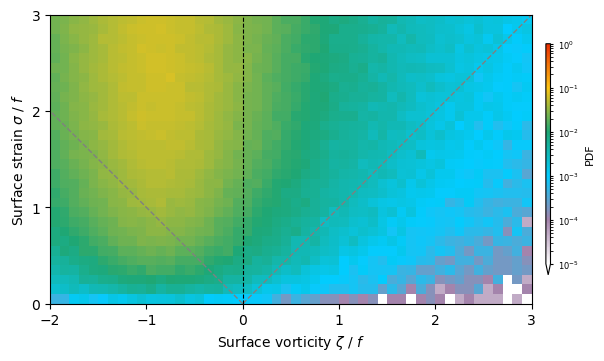

In [9]:
plt.close()
plt.figure(figsize=(6, 3.5), constrained_layout=True)

colorlist = ['xkcd:white', 'xkcd:heather', 'xkcd:bright sky blue', 'xkcd:jade', 'xkcd:golden yellow', 'xkcd:tomato red']
nodes = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
# colorlist = ['xkcd:white', 'xkcd:azure', 'xkcd:golden yellow', 'xkcd:tomato red']
# nodes = [0.0, 0.3, 0.6, 1.0]

cmap_pdf = LinearSegmentedColormap.from_list('pdf', list(zip(nodes, colorlist)))

pcm = plt.pcolormesh(vort_binc, strn_binc, pdf_vort_strn.T, cmap=cmap_pdf, norm=mcolors.LogNorm(1e-5,1))
plt.plot([0, 20], [0, 20], 'gray', ls='--', lw=1)
plt.plot([0,-10], [0, 10], 'gray', ls='--', lw=1)
plt.axvline(0, c='k', ls='--', lw=0.8)

cbar = plt.colorbar(pcm, ax=plt.gca(), location='right', shrink=0.8, aspect=50, pad=0.02, extend='min')
cbar.ax.tick_params(labelsize=6, length=2)
cbar.set_label(label='PDF', size=8)

plt.gca().set_aspect('equal')
plt.xlim(-2,3)
plt.ylim(0, 3)
plt.gca().set_yticks(np.linspace(0,3,4))
plt.xlabel(r'Surface vorticity $\zeta$ / $f$')
plt.ylabel(r'Surface strain $\sigma$ / $f$');

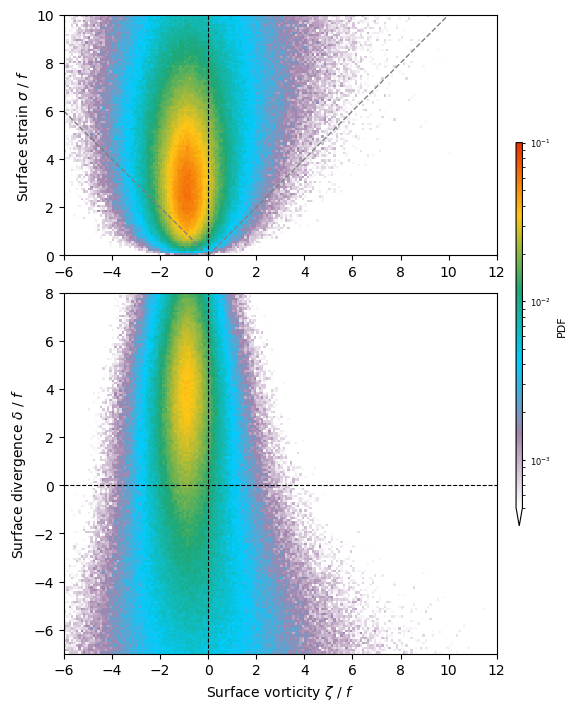

In [10]:
plt.close()
fig = plt.figure(figsize=(6, 7), constrained_layout=True)
gs = fig.add_gridspec(5, 1, hspace=0, wspace=0, top=1, bottom=0, right=1, left=0)

ax0 = fig.add_subplot(gs[:2,:])
pcm = ax0.pcolormesh(vort_binc, strn_binc, pdf_vort_strn.T, cmap=cmap_pdf, norm=mcolors.LogNorm(5e-4,0.1))
ax0.plot([0, 20], [0, 20], 'gray', ls='--', lw=1)
ax0.plot([0,-10], [0, 10], 'gray', ls='--', lw=1)
ax0.axvline(0, c='k', ls='--', lw=0.8)

ax1 = fig.add_subplot(gs[2:,:], sharex=ax0)
pcm = ax1.pcolormesh(vort_binc, divg_binc, pdf_vort_divg.T, cmap=cmap_pdf, norm=mcolors.LogNorm(5e-4,0.1))
ax1.axvline(0, c='k', ls='--', lw=0.8)
ax1.axhline(0, c='k', ls='--', lw=0.8)
cbar = plt.colorbar(pcm, ax=[ax0,ax1], location='right', shrink=0.6, aspect=60, pad=0.02, extend='min')
cbar.ax.tick_params(labelsize=6, length=2)
cbar.set_label(label='PDF', size=8)

ax0.set_aspect('equal')
ax1.set_aspect('equal')
ax0.set_ylim(0, 10)
ax1.set_ylim(-7,8)
ax1.set_xlim(-6,12)
ax1.set_xlabel(r'Surface vorticity $\zeta$ / $f$')
ax0.set_ylabel(r'Surface strain $\sigma$ / $f$')
ax1.set_ylabel(r'Surface divergence $\delta$ / $f$');

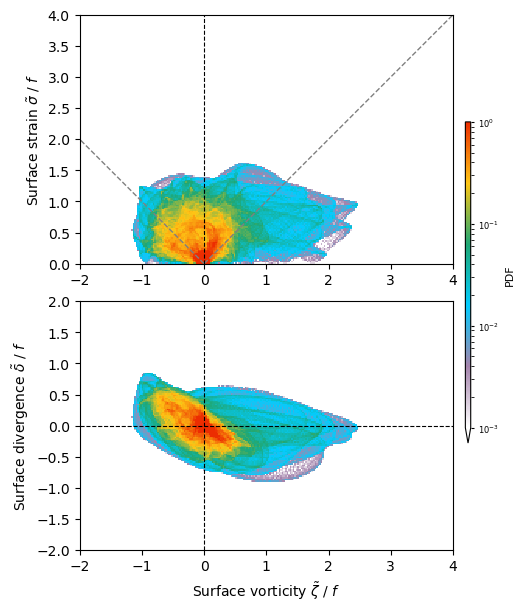

In [15]:
plt.close()
fig = plt.figure(figsize=(5.2, 6), constrained_layout=True)
gs = fig.add_gridspec(6, 1, hspace=0, wspace=0, top=1, bottom=0, right=1, left=0)

ax0 = fig.add_subplot(gs[:3,:])
pcm = ax0.pcolormesh(vort_binc, strn_binc, pdf_vort_strn.T, cmap=cmap_pdf, norm=mcolors.LogNorm(1e-3,1))
ax0.plot([0, 20], [0, 20], 'gray', ls='--', lw=1)
ax0.plot([0,-10], [0, 10], 'gray', ls='--', lw=1)
ax0.axvline(0, c='k', ls='--', lw=0.8)

ax1 = fig.add_subplot(gs[3:,:], sharex=ax0)
pcm = ax1.pcolormesh(vort_binc, divg_binc, pdf_vort_divg.T, cmap=cmap_pdf, norm=mcolors.LogNorm(1e-3,1))
ax1.axvline(0, c='k', ls='--', lw=0.8)
ax1.axhline(0, c='k', ls='--', lw=0.8)
cbar = plt.colorbar(pcm, ax=[ax0,ax1], location='right', shrink=0.6, aspect=60, pad=0.02, extend='min')
cbar.ax.tick_params(labelsize=6, length=2)
cbar.set_label(label='PDF', size=8)

ax0.set_ylim(0, 4)
ax1.set_xlim(-2,4)
ax1.set_ylim(-2,2)
ax1.set_xlim(-2,4)
ax0.set_aspect('equal')
ax1.set_aspect('equal')
ax1.set_xlabel(r'Surface vorticity $\tilde{\zeta}$ / $f$')
ax0.set_ylabel(r'Surface strain $\tilde{\sigma}$ / $f$')
ax1.set_ylabel(r'Surface divergence $\tilde{\delta}$ / $f$');

#### Conditional averages on vorticity-strain space

In [25]:
mask = ds.xC > -10
w_count_vort_strn,_,_ = np.histogram2d(ds['ζ'].isel(zC=-1).where(mask,drop=True).data.flatten()/ds.f,
                                       ds['σ'].isel(zC=-1).where(mask,drop=True).data.flatten()/ds.f,
                                       weights=ds['w'].isel(zC=-3).where(mask,drop=True).data.flatten(),
                                       bins=(vort_bin_edges, strn_bin_edges), density=False)
w_count_vort_divg,_,_ = np.histogram2d(ds['ζ'].isel(zC=-1).where(mask,drop=True).data.flatten()/ds.f,
                                       ds['δ'].isel(zC=-1).where(mask,drop=True).data.flatten()/ds.f,
                                       weights=ds['w'].isel(zC=-3).where(mask,drop=True).data.flatten(),
                                       bins=(vort_bin_edges, divg_bin_edges), density=False)
wc_count_vort_strn,_,_ = np.histogram2d(ds['ζ'].isel(zC=-1).where(mask,drop=True).data.flatten()/ds.f,
                                        ds['σ'].isel(zC=-1).where(mask,drop=True).data.flatten()/ds.f,
                                        weights=(ds['w'].isel(zC=-3) * (ds['c7'].isel(zC=-3) - ds['c7'].isel(zC=-3).mean(['xC', 'yC']))\
                                                 ).where(mask,drop=True).data.flatten(),
                                        bins=(vort_bin_edges, strn_bin_edges), density=False)
wc_count_vort_divg,_,_ = np.histogram2d(ds['ζ'].isel(zC=-1).where(mask,drop=True).data.flatten()/ds.f,
                                        ds['δ'].isel(zC=-1).where(mask,drop=True).data.flatten()/ds.f,
                                        weights=(ds['w'].isel(zC=-3) * (ds['c7'].isel(zC=-3) - ds['c7'].isel(zC=-3).mean(['xC', 'yC']))\
                                                 ).where(mask,drop=True).data.flatten(),
                                        bins=(vort_bin_edges, divg_bin_edges), density=False)
w_vort_strn  = w_count_vort_strn / np.where(pdf_vort_strn<5e-4, np.nan, count_vort_strn)
w_vort_divg  = w_count_vort_divg / np.where(pdf_vort_divg<5e-4, np.nan, count_vort_divg)
wc_vort_strn = wc_count_vort_strn / np.where(pdf_vort_strn<5e-4, np.nan, count_vort_strn)
wc_vort_divg = wc_count_vort_divg / np.where(pdf_vort_divg<5e-4, np.nan, count_vort_divg)

In [26]:
mask = dsl.xC > -10
w_count_vort_strn,_,_ = np.histogram2d(dsl['ζ'].isel(zC=iz).where(mask,drop=True).data.flatten()/dsl.f,
                                       dsl['σ'].isel(zC=iz).where(mask,drop=True).data.flatten()/dsl.f,
                                       weights=dsl['w'].isel(zC=iz).where(mask,drop=True).data.flatten(),
                                       bins=(vort_bin_edges, strn_bin_edges), density=False)
w_count_vort_divg,_,_ = np.histogram2d(dsl['ζ'].isel(zC=iz).where(mask,drop=True).data.flatten()/dsl.f,
                                       dsl['δ'].isel(zC=iz).where(mask,drop=True).data.flatten()/dsl.f,
                                       weights=dsl['w'].isel(zC=iz).where(mask,drop=True).data.flatten(),
                                       bins=(vort_bin_edges, divg_bin_edges), density=False)
wc_count_vort_strn,_,_ = np.histogram2d(dsl['ζ'].isel(zC=iz).where(mask,drop=True).data.flatten()/dsl.f,
                                        dsl['σ'].isel(zC=iz).where(mask,drop=True).data.flatten()/dsl.f,
                                        weights=(dsl['w'].isel(zC=iz) * (dsl['c7'].isel(zC=iz) - dsl['c7'].isel(zC=iz).mean(['xC', 'yC']))\
                                                 ).where(mask,drop=True).data.flatten(),
                                        bins=(vort_bin_edges, strn_bin_edges), density=False)
wc_count_vort_divg,_,_ = np.histogram2d(dsl['ζ'].isel(zC=iz).where(mask,drop=True).data.flatten()/dsl.f,
                                        dsl['δ'].isel(zC=iz).where(mask,drop=True).data.flatten()/dsl.f,
                                        weights=(dsl['w'].isel(zC=iz) * (dsl['c7'].isel(zC=iz) - dsl['c7'].isel(zC=iz).mean(['xC', 'yC']))\
                                                 ).where(mask,drop=True).data.flatten(),
                                        bins=(vort_bin_edges, divg_bin_edges), density=False)
w_vort_strn  = w_count_vort_strn / np.where(pdf_vort_strn<5e-4, np.nan, count_vort_strn)
w_vort_divg  = w_count_vort_divg / np.where(pdf_vort_divg<5e-4, np.nan, count_vort_divg)
wc_vort_strn = wc_count_vort_strn / np.where(pdf_vort_strn<5e-4, np.nan, count_vort_strn)
wc_vort_divg = wc_count_vort_divg / np.where(pdf_vort_divg<5e-4, np.nan, count_vort_divg)

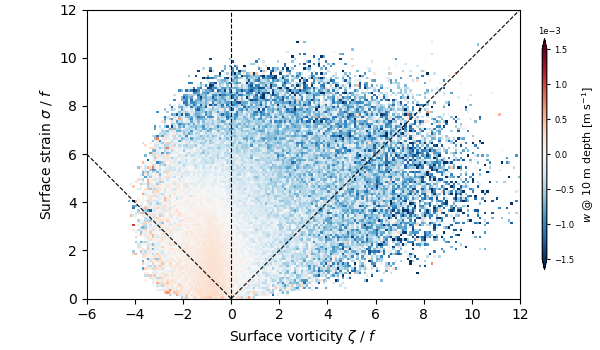

In [43]:
plt.close()
plt.figure(figsize=(6, 3.5), constrained_layout=True)

pcm = plt.pcolormesh(vort_binc, strn_binc, w_vort_strn.T, cmap='RdBu_r', vmin=-1.5e-3, vmax=1.5e-3)
plt.plot([0, 20], [0, 20], 'k', ls='--', lw=0.8)
plt.plot([0,-10], [0, 10], 'k', ls='--', lw=0.8)
plt.axvline(0, c='k', ls='--', lw=0.8)

cbar = plt.colorbar(pcm, ax=plt.gca(), location='right', shrink=0.8, aspect=50, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=6, length=2)
cbar.set_label(label='$w$ @ 30 m depth [m s$^{-1}$]', size=8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.tick_params(labelsize=6, length=2)
# cbar.ax.locator_params(nbins=7)
cbar.ax.yaxis.get_offset_text().set_fontsize(6)
cbar.ax.yaxis.get_offset_text().set_position((4, 0.8))

plt.gca().set_aspect('equal')
plt.xlim(-6,12)
plt.ylim(0, 12)
plt.xlabel(r'Surface vorticity $\zeta$ / $f$')
plt.ylabel(r'Surface strain $\sigma$ / $f$');

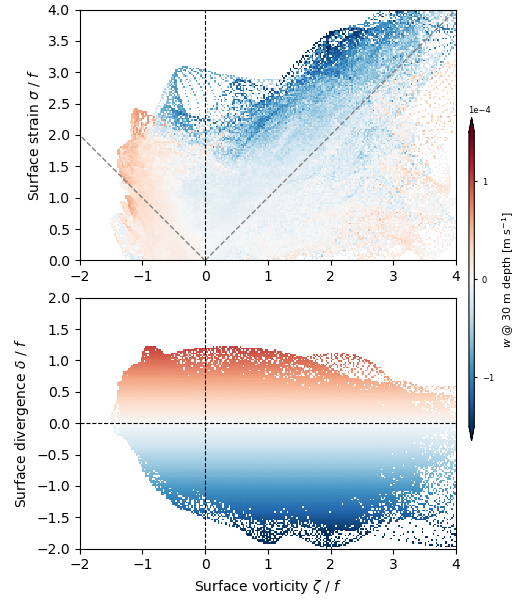

In [30]:
plt.close()
fig = plt.figure(figsize=(5.2, 6), constrained_layout=True)
gs = fig.add_gridspec(6, 1, hspace=0, wspace=0, top=1, bottom=0, right=1, left=0)

ax0 = fig.add_subplot(gs[:3,:])
pcm = ax0.pcolormesh(vort_binc, strn_binc, w_vort_strn.T, cmap='RdBu_r', vmin=-1.5e-4, vmax=1.5e-4)
ax0.plot([0, 20], [0, 20], 'gray', ls='--', lw=1)
ax0.plot([0,-10], [0, 10], 'gray', ls='--', lw=1)
ax0.axvline(0, c='k', ls='--', lw=0.8)

ax1 = fig.add_subplot(gs[3:,:], sharex=ax0)
pcm = ax1.pcolormesh(vort_binc, divg_binc, w_vort_divg.T, cmap='RdBu_r', vmin=-1.5e-4, vmax=1.5e-4)
ax1.axvline(0, c='k', ls='--', lw=0.8)
ax1.axhline(0, c='k', ls='--', lw=0.8)
cbar = plt.colorbar(pcm, ax=[ax0,ax1], location='right', shrink=0.6, aspect=60, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=6, length=2)
cbar.set_label(label='$w$ @ 30 m depth [m s$^{-1}$]', size=8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.locator_params(nbins=5)
cbar.ax.yaxis.get_offset_text().set_fontsize(6)
cbar.ax.yaxis.get_offset_text().set_position((4, 0.8))

ax0.set_ylim(0, 4)
ax1.set_xlim(-2,4)
ax1.set_ylim(-2,2)
ax1.set_xlim(-2,4)
ax0.set_aspect('equal')
ax1.set_aspect('equal')
ax1.set_xlabel(r'Surface vorticity $\zeta$ / $f$')
ax0.set_ylabel(r'Surface strain $\sigma$ / $f$')
ax1.set_ylabel(r'Surface divergence $\delta$ / $f$');

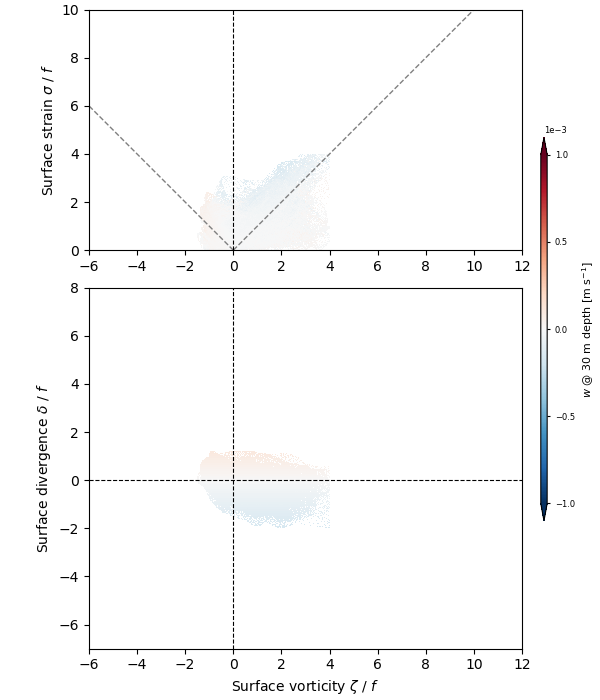

In [31]:
plt.close()
fig = plt.figure(figsize=(6, 7), constrained_layout=True)
gs = fig.add_gridspec(5, 1, hspace=0, wspace=0, top=1, bottom=0, right=1, left=0)

ax0 = fig.add_subplot(gs[:2,:])
pcm = ax0.pcolormesh(vort_binc, strn_binc, w_vort_strn.T, cmap='RdBu_r', vmin=-1e-3, vmax=1e-3)
ax0.plot([0, 20], [0, 20], 'gray', ls='--', lw=1)
ax0.plot([0,-10], [0, 10], 'gray', ls='--', lw=1)
ax0.axvline(0, c='k', ls='--', lw=0.8)

ax1 = fig.add_subplot(gs[2:,:], sharex=ax0)
pcm = ax1.pcolormesh(vort_binc, divg_binc, w_vort_divg.T, cmap='RdBu_r', vmin=-1e-3, vmax=1e-3)
ax1.axvline(0, c='k', ls='--', lw=0.8)
ax1.axhline(0, c='k', ls='--', lw=0.8)
cbar = plt.colorbar(pcm, ax=[ax0,ax1], location='right', shrink=0.6, aspect=60, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=6, length=2)
cbar.set_label(label='$w$ @ 30 m depth [m s$^{-1}$]', size=8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.locator_params(nbins=5)
cbar.ax.yaxis.get_offset_text().set_fontsize(6)
cbar.ax.yaxis.get_offset_text().set_position((4, 0.8))

ax0.set_aspect('equal')
ax1.set_aspect('equal')
ax0.set_ylim(0, 10)
ax1.set_ylim(-7,8)
ax1.set_xlim(-6,12)
ax1.set_xlabel(r'Surface vorticity $\zeta$ / $f$')
ax0.set_ylabel(r'Surface strain $\sigma$ / $f$')
ax1.set_ylabel(r'Surface divergence $\delta$ / $f$');

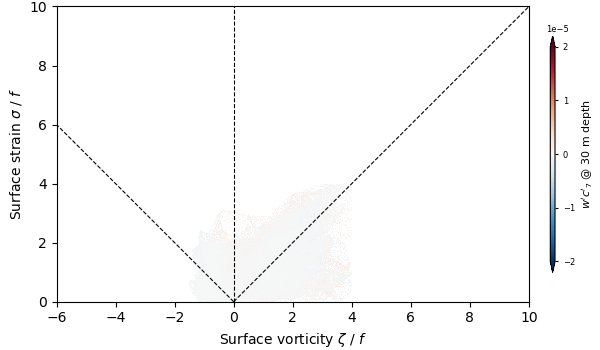

In [32]:
plt.close()
plt.figure(figsize=(6, 3.5), constrained_layout=True)

pcm = plt.pcolormesh(vort_binc, strn_binc, wc_vort_strn.T, cmap='RdBu_r', vmin=-2e-5, vmax=2e-5)
plt.plot([0, 20], [0, 20], 'k', ls='--', lw=0.8)
plt.plot([0,-10], [0, 10], 'k', ls='--', lw=0.8)
plt.axvline(0, c='k', ls='--', lw=0.8)

cbar = plt.colorbar(pcm, ax=plt.gca(), location='right', shrink=0.8, aspect=50, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=6, length=2)
cbar.set_label(label=r"$w'c'_7$ @ 30 m depth", size=8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.tick_params(labelsize=6, length=2)
cbar.ax.locator_params(nbins=5)
cbar.ax.yaxis.get_offset_text().set_fontsize(6)
cbar.ax.yaxis.get_offset_text().set_position((4, 0.8))

plt.gca().set_aspect('equal')
plt.xlim(-6,10)
plt.ylim(0, 10)
plt.xlabel(r'Surface vorticity $\zeta$ / $f$')
plt.ylabel(r'Surface strain $\sigma$ / $f$');

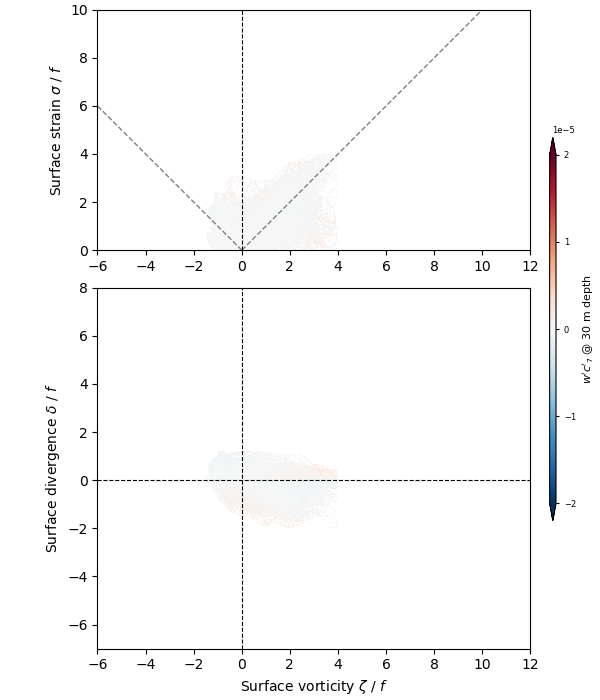

In [33]:
plt.close()
fig = plt.figure(figsize=(6, 7), constrained_layout=True)
gs = fig.add_gridspec(5, 1, hspace=0, wspace=0, top=1, bottom=0, right=1, left=0)

ax0 = fig.add_subplot(gs[:2,:])
pcm = ax0.pcolormesh(vort_binc, strn_binc, wc_vort_strn.T, cmap='RdBu_r', vmin=-2e-5, vmax=2e-5)
ax0.plot([0, 20], [0, 20], 'gray', ls='--', lw=1)
ax0.plot([0,-10], [0, 10], 'gray', ls='--', lw=1)
ax0.axvline(0, c='k', ls='--', lw=0.8)

ax1 = fig.add_subplot(gs[2:,:], sharex=ax0)
pcm = ax1.pcolormesh(vort_binc, divg_binc, wc_vort_divg.T, cmap='RdBu_r', vmin=-2e-5, vmax=2e-5)
ax1.axvline(0, c='k', ls='--', lw=0.8)
ax1.axhline(0, c='k', ls='--', lw=0.8)
cbar = plt.colorbar(pcm, ax=[ax0,ax1], location='right', shrink=0.6, aspect=60, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=6, length=2)
cbar.set_label(label=r"$w'c'_7$ @ 30 m depth", size=8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.locator_params(nbins=5)
cbar.ax.yaxis.get_offset_text().set_fontsize(6)
cbar.ax.yaxis.get_offset_text().set_position((4, 0.8))

ax0.set_aspect('equal')
ax1.set_aspect('equal')
ax0.set_ylim(0, 10)
ax1.set_ylim(-7,8)
ax1.set_xlim(-6,12)
ax1.set_xlabel(r'Surface vorticity $\zeta$ / $f$')
ax0.set_ylabel(r'Surface strain $\sigma$ / $f$')
ax1.set_ylabel(r'Surface divergence $\delta$ / $f$');

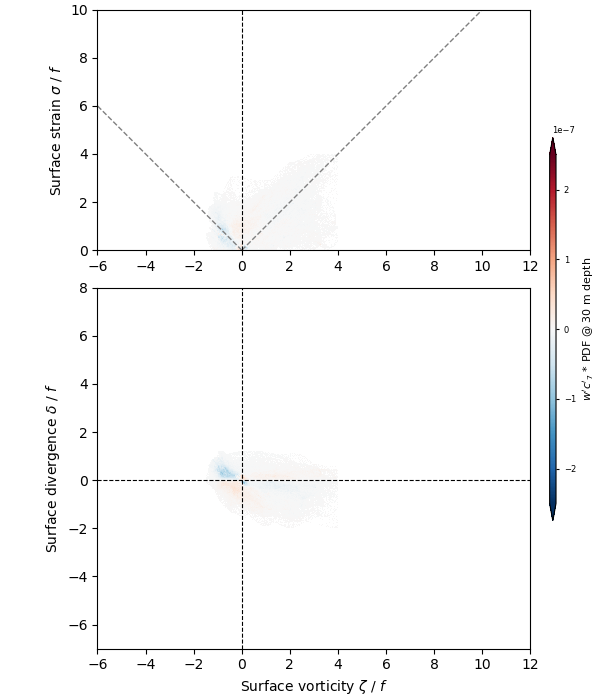

In [34]:
plt.close()
fig = plt.figure(figsize=(6, 7), constrained_layout=True)
gs = fig.add_gridspec(5, 1, hspace=0, wspace=0, top=1, bottom=0, right=1, left=0)

ax0 = fig.add_subplot(gs[:2,:])
pcm = ax0.pcolormesh(vort_binc, strn_binc, (wc_vort_strn*pdf_vort_strn).T, cmap='RdBu_r', vmin=-2.5e-7, vmax=2.5e-7)
ax0.plot([0, 20], [0, 20], 'gray', ls='--', lw=1)
ax0.plot([0,-10], [0, 10], 'gray', ls='--', lw=1)
ax0.axvline(0, c='k', ls='--', lw=0.8)

ax1 = fig.add_subplot(gs[2:,:], sharex=ax0)
pcm = ax1.pcolormesh(vort_binc, divg_binc, (wc_vort_divg*pdf_vort_divg).T, cmap='RdBu_r', vmin=-2.5e-7, vmax=2.5e-7)
ax1.axvline(0, c='k', ls='--', lw=0.8)
ax1.axhline(0, c='k', ls='--', lw=0.8)
cbar = plt.colorbar(pcm, ax=[ax0,ax1], location='right', shrink=0.6, aspect=60, pad=0.02, extend='both')
cbar.ax.tick_params(labelsize=6, length=2)
cbar.set_label(label=r"$w'c'_7 $ * PDF @ 30 m depth", size=8)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.locator_params(nbins=5)
cbar.ax.yaxis.get_offset_text().set_fontsize(6)
cbar.ax.yaxis.get_offset_text().set_position((4, 0.8))

ax0.set_aspect('equal')
ax1.set_aspect('equal')
ax0.set_ylim(0, 10)
ax1.set_ylim(-7,8)
ax1.set_xlim(-6,12)
ax1.set_xlabel(r'Surface vorticity $\zeta$ / $f$')
ax0.set_ylabel(r'Surface strain $\sigma$ / $f$')
ax1.set_ylabel(r'Surface divergence $\delta$ / $f$');

#### Coasrse-graining 

In [38]:
spec_u0 = TWODimensional_spec(ds.u.isel(time=-1, zC=-1), 4, 4)
spec_b0 = TWODimensional_spec(ds.b.isel(time=-1, zC=-1), 4, 4)
# spec_c1 = TWODimensional_spec(ds.c1.isel(zC=iz), 4, 4)
# spec_c4 = TWODimensional_spec(ds.c4.isel(zC=iz), 4, 4)
# spec_c7 = TWODimensional_spec(ds.c7.isel(zC=iz), 4, 4)

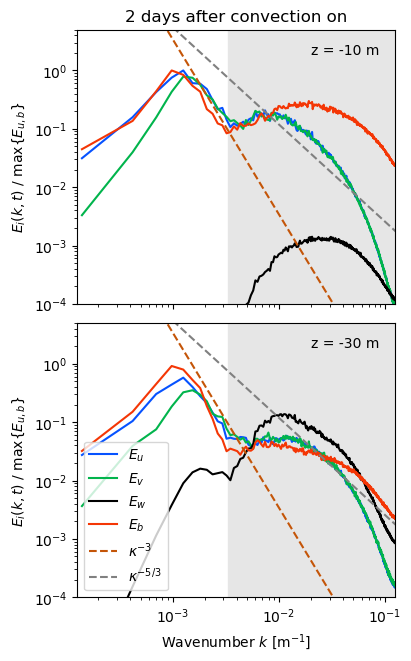

In [40]:
plt.close()
_,ax = plt.subplots(2,1, figsize=(4,6.5), constrained_layout=True, sharex=True, sharey=True)

kref = np.array([1, 2e2]) * 7e-4
Esbm = np.array([1, 2e2**(-3)]) * 10
Etur = np.array([1, 2e2**(-5/3)]) * 10
lcut = 300

itime = 0
spec_u = TWODimensional_spec(ds.u.isel(time=itime, zC=-1), 4, 4)
spec_v = TWODimensional_spec(ds.v.isel(time=itime, zC=-1), 4, 4)
spec_w = TWODimensional_spec(ds.w.isel(time=itime, zC=-1), 4, 4)
spec_b = TWODimensional_spec(ds.b.isel(time=itime, zC=-1), 4, 4)
ax[0].loglog(spec_u.ki, spec_u.ispec/spec_u0.ispec.max(), 'xkcd:electric blue')
ax[0].loglog(spec_v.ki, spec_v.ispec/spec_u0.ispec.max(), 'xkcd:shamrock')
ax[0].loglog(spec_w.ki, spec_w.ispec/spec_u0.ispec.max(), 'k')
ax[0].loglog(spec_b.ki, spec_b.ispec/spec_b0.ispec.max(), 'xkcd:orangish red')
ax[0].loglog(kref, Esbm, '--', c='xkcd:rust orange')
ax[0].loglog(kref, Etur, '--', c='gray')
ax[0].axvspan(1/lcut, 1/8, color='0.9')
ax[0].text(0.95, 0.95, 'z = -10 m', ha='right', va='top', transform=ax[0].transAxes)

spec_u = TWODimensional_spec(ds.u.isel(time=itime, zC=0), 4, 4)
spec_v = TWODimensional_spec(ds.v.isel(time=itime, zC=0), 4, 4)
spec_w = TWODimensional_spec(ds.w.isel(time=itime, zC=0), 4, 4)
spec_b = TWODimensional_spec(ds.b.isel(time=itime, zC=0), 4, 4)
ax[1].loglog(spec_u.ki, spec_u.ispec/spec_u0.ispec.max(), 'xkcd:electric blue')
ax[1].loglog(spec_v.ki, spec_v.ispec/spec_u0.ispec.max(), 'xkcd:shamrock')
ax[1].loglog(spec_w.ki, spec_w.ispec/spec_u0.ispec.max(), 'k')
ax[1].loglog(spec_b.ki, spec_b.ispec/spec_b0.ispec.max(), 'xkcd:orangish red')
ax[1].loglog(kref, Esbm, '--', c='xkcd:rust orange')
ax[1].loglog(kref, Etur, '--', c='gray')
ax[1].axvspan(1/lcut, 1/8, color='0.9')
ax[1].text(0.95, 0.95, 'z = -30 m', ha='right', va='top', transform=ax[1].transAxes)
# plt.loglog(spec_c1.ki, spec_c1.ispec/spec_c1.ispec[0], 'C1')
# plt.loglog(spec_c4.ki, spec_c4.ispec/spec_c4.ispec[0], 'C5')
# plt.loglog(spec_c7.ki, spec_c7.ispec/spec_c7.ispec[0], 'c')

ax[1].legend([r'$E_u$', r'$E_v$', r'$E_w$', r'$E_b$', r'$\kappa^{-3}$', r'$\kappa^{-5/3}$'],
            # r'$E_{c_1}$', r'$E_{c_4}$', r'$E_{c_7}$'])
             loc='lower left')
plt.xlim(1/8e3, 1/8)
plt.ylim(1e-4, 5)
ax[1].set_xlabel(r'Wavenumber $k$ [m$^{-1}$]')
ax[1].set_ylabel(r'$E_i(k, t)$ / max{$E_{u,b}$}')
ax[0].set_ylabel(r'$E_i(k, t)$ / max{$E_{u,b}$}')
ax[0].set_title(f'{itime+2} days after convection on');

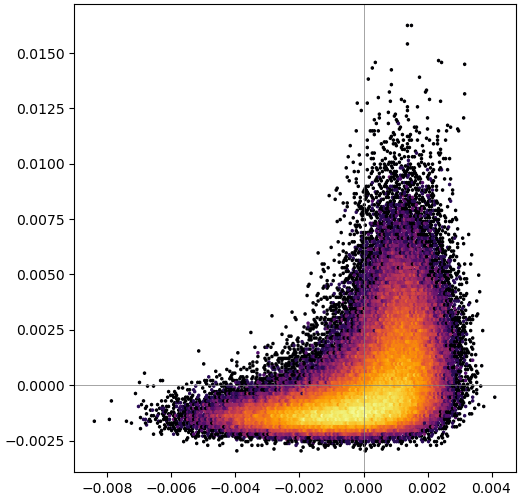

In [35]:
plt.close()
plt.figure(figsize=(5.2, 5), constrained_layout=True)

no_front = (ds.xC > -0.2)   & (ds.xC < 1.2)   & (ds.yC > 0)   & (ds.yC < 1.8)
# at_front = (ds.xC > 0.5) & (ds.xC < 1.5) & (ds.yC > 1.9) & (ds.yC < 2.9)

# no_front = (ds.xC < -3.3) | (ds.xC > 3.4) | ((ds.xC > -0.2) & (ds.xC < 0.3))
at_front = (ds.xC > -2.9) & (ds.xC < -1.9)
# at_front = (xyplane1.xC > 0.5) & (xyplane1.xC < 2.9)# & (xyplane1.yC > 1.9) & (xyplane1.yC < 2.9)
# plt.scatter(xyplane1.b.isel(time=-1, zC=0) - xyplane1.b.isel(time=-1, zC=0).mean(['yC']),
#             xyplane1.w.isel(time=-1, zC=0) - xyplane1.w.isel(time=-1, zC=0).mean(['yC']), 1, 'gray')

front = False
if front:
    mask = at_front
else:
    mask = no_front

iz = 0
# reduce_dims = ['yC', 'xC']
reduce_dims = ['yC']
bp = ds.b.isel(zC=iz).where(mask,drop=True)  - ds.b.isel(zC=iz).where(mask,drop=True).mean(reduce_dims)
cp = ds.c7.isel(zC=iz).where(mask,drop=True) - ds.c7.isel(zC=iz).where(mask,drop=True).mean(reduce_dims)
wp = ds.w.isel(zC=iz).where(mask,drop=True)  - ds.w.isel(zC=iz).where(mask,drop=True).mean(reduce_dims)

plt.hexbin(wp, cp, bins='log', gridsize=200, cmap='inferno')
# plt.hexbin(wp.where(mask,drop=True), cp.where(mask,drop=True), bins='log', gridsize=200, cmap='inferno')
plt.axvline(0, c='gray', lw=0.5)
plt.axhline(0, c='gray', lw=0.5);

In [40]:
w_bin_edges = np.linspace(-1e-2, 1e-2, 201)
b_bin_edges = np.linspace(-6e-6, 4e-6, 201)
c_bin_edges = np.linspace(-0.04, 0.14, 201)
w_binc = (w_bin_edges[:-1] + w_bin_edges[1:])/2
b_binc = (b_bin_edges[:-1] + b_bin_edges[1:])/2
c_binc = (c_bin_edges[:-1] + c_bin_edges[1:])/2
dw = w_bin_edges[1] - w_bin_edges[0]
db = b_bin_edges[1] - b_bin_edges[0]
dc = c_bin_edges[1] - c_bin_edges[0]

iz = 0
mask = (dsl['M²'].isel(zC=iz)/ds.attrs['M²']) > 0.2
count_wbf,_,_ = np.histogram2d(dsh['w'].isel(zC=iz).where(mask,drop=True).data.flatten(),
                               dsh['b'].isel(zC=iz).where(mask,drop=True).data.flatten(),
                               bins=(w_bin_edges, b_bin_edges), density=False)
count_wcf,_,_ = np.histogram2d(dsh['w'].isel(zC=iz).where(mask,drop=True).data.flatten(),
                               dsh['c7'].isel(zC=iz).where(mask,drop=True).data.flatten(),
                               bins=(w_bin_edges, c_bin_edges), density=False)
pdf_wbf = count_wbf / (dw*db) / (dsh.xC.size*dsh.yC.size)
pdf_wcf = count_wcf / (dw*dc) / (dsh.xC.size*dsh.yC.size)


mask = ((dsl['M²'].isel(zC=iz)/ds.attrs['M²']) <= 0.01)
# mask = (dsh.xC > -0.2)   & (dsh.xC < 1.2)   & (dsh.yC > 0)   & (dsh.yC < 1.8)
count_wbn,_,_ = np.histogram2d(dsh['w'].isel(zC=iz).where(mask,drop=True).data.flatten(),
                               dsh['b'].isel(zC=iz).where(mask,drop=True).data.flatten(),
                               bins=(w_bin_edges, b_bin_edges), density=False)
count_wcn,_,_ = np.histogram2d(dsh['w'].isel(zC=iz).where(mask,drop=True).data.flatten(),
                               dsh['c7'].isel(zC=iz).where(mask,drop=True).data.flatten(),
                               bins=(w_bin_edges, c_bin_edges), density=False)
pdf_wbn = count_wbn / (dw*db) / (dsh.xC.size*dsh.yC.size)
pdf_wcn = count_wcn / (dw*dc) / (dsh.xC.size*dsh.yC.size)

In [37]:
w_bin_edges = np.linspace(-4e-4, 4e-4, 201)
b_bin_edges = np.linspace(-6e-6, 6e-6, 201)
c_bin_edges = np.linspace(-0.02, 0.07, 201)
w_binc = (w_bin_edges[:-1] + w_bin_edges[1:])/2
b_binc = (b_bin_edges[:-1] + b_bin_edges[1:])/2
c_binc = (c_bin_edges[:-1] + c_bin_edges[1:])/2
dw = w_bin_edges[1] - w_bin_edges[0]
db = b_bin_edges[1] - b_bin_edges[0]
dc = c_bin_edges[1] - c_bin_edges[0]

mask = (dsl['M²'].isel(zC=iz)/ds.attrs['M²']) > 0.2
count_wb_sbm,_,_ = np.histogram2d((dsl['w'].isel(zC=iz) - dsl['w'].isel(zC=iz).mean('yC')).where(mask,drop=True).data.flatten(),
                               (dsl['b'].isel(zC=iz) - dsl['b'].isel(zC=iz).mean('yC')).where(mask,drop=True).data.flatten(),
                               bins=(w_bin_edges, b_bin_edges), density=False)
count_wc_sbm,_,_ = np.histogram2d((dsl['w'].isel(zC=iz) - dsl['w'].isel(zC=iz).mean('yC')).where(mask,drop=True).data.flatten(),
                               (dsl['c7'].isel(zC=iz) - dsl['c7'].isel(zC=iz).mean('yC')).where(mask,drop=True).data.flatten(),
                               bins=(w_bin_edges, c_bin_edges), density=False)
pdf_wb_sbm = count_wb_sbm / (dw*db) / (dsl.xC.size*dsl.yC.size)
pdf_wc_sbm = count_wc_sbm / (dw*dc) / (dsl.xC.size*dsl.yC.size)

In [44]:
pdf_wc_sbm.max()/1e5

2.7694444444444577

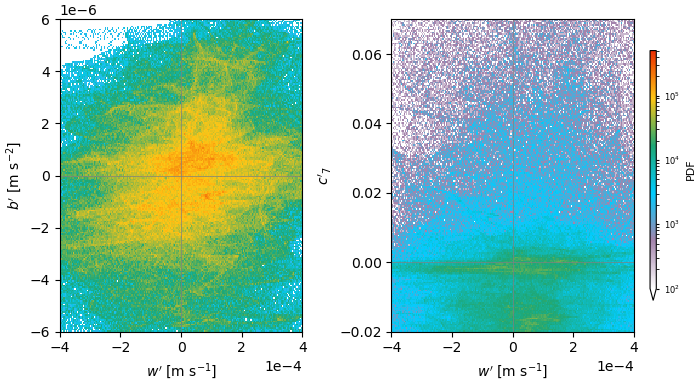

In [38]:
plt.close()
_,ax = plt.subplots(1,2, figsize=(7, 3.85), sharex=True, constrained_layout=True)

ax[0].pcolormesh(w_binc, b_binc, pdf_wb_sbm.T, cmap=cmap_pdf, norm=mcolors.LogNorm(1e5, 5e8))
ax[0].axvline(0, c='gray', lw=0.5)
ax[0].axhline(0, c='gray', lw=0.5)
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 0))
# ax[0].set_title(r'$\widetilde{M^2}$ / $M_0^2$ > 0.2')
ax[0].set_ylabel(r"$b'$ [m s$^{-2}$]")
ax[0].set_xlabel(r"$w'$ [m s$^{-1}$]")

pcm = ax[1].pcolormesh(w_binc, c_binc, pdf_wc_sbm.T, cmap=cmap_pdf, norm=mcolors.LogNorm(1e2, 5e5))
ax[1].axvline(0, c='gray', lw=0.5)
ax[1].axhline(0, c='gray', lw=0.5)
cbar = plt.colorbar(pcm, ax=ax[:], location='right', shrink=0.8, aspect=40, pad=0.02, extend='min')
cbar.ax.tick_params(labelsize=6, length=2)
cbar.set_label(label='PDF', size=8)

ax[1].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
# ax[1].set_title(r'$\widetilde{M^2}$ / $M_0^2$ < 0.01')
ax[1].set_ylabel(r"$c'_7$")
ax[1].set_xlabel(r"$w'$ [m s$^{-1}$]");

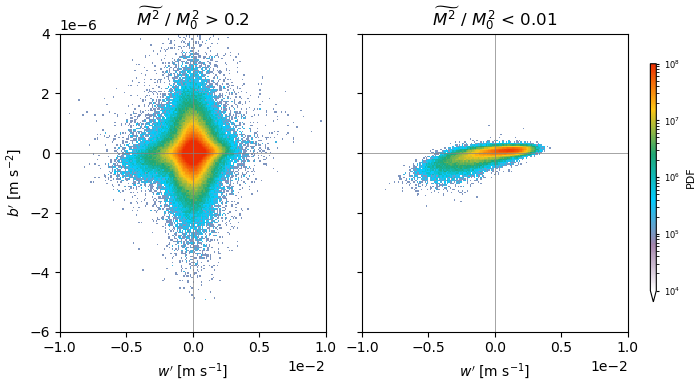

In [41]:
plt.close()
_,ax = plt.subplots(1,2, figsize=(7, 3.85), sharex=True, sharey=True, constrained_layout=True)

ax[0].pcolormesh(w_binc, b_binc, pdf_wbf.T, cmap=cmap_pdf, norm=mcolors.LogNorm(1e4, 1e8))
ax[0].axvline(0, c='gray', lw=0.5)
ax[0].axhline(0, c='gray', lw=0.5)
ax[0].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax[0].set_title(r'$\widetilde{M^2}$ / $M_0^2$ > 0.2')
ax[0].set_ylabel(r"$b'$ [m s$^{-2}$]")
ax[0].set_xlabel(r"$w'$ [m s$^{-1}$]")

pcm = ax[1].pcolormesh(w_binc, b_binc, pdf_wbn.T, cmap=cmap_pdf, norm=mcolors.LogNorm(1e4, 1e8))
ax[1].axvline(0, c='gray', lw=0.5)
ax[1].axhline(0, c='gray', lw=0.5)
cbar = plt.colorbar(pcm, ax=ax[:], location='right', shrink=0.8, aspect=40, pad=0.02, extend='min')
cbar.ax.tick_params(labelsize=6, length=2)
cbar.set_label(label='PDF', size=8)

ax[1].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax[1].set_title(r'$\widetilde{M^2}$ / $M_0^2$ < 0.01')
ax[1].set_xlabel(r"$w'$ [m s$^{-1}$]");

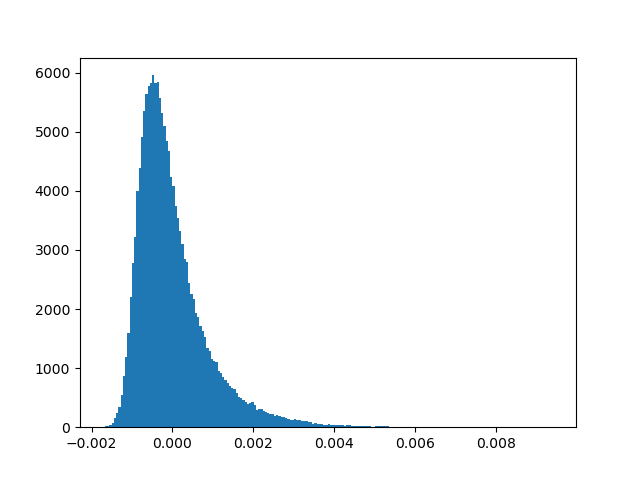

In [148]:
plt.close()
plt.figure()
mask = (dsh.xC > -0.2)   & (dsh.xC < 1.2)   & (dsh.yC > 0)   & (dsh.yC < 1.8)
plt.hist(dsh['c7'].isel(zC=iz).where(mask,drop=True).data.flatten(), 200);
# mask = ((dsl['M²'].isel(zC=iz)/ds.attrs['M²']) <= 0.01) & (dsh.xC > 0)
# plt.hist(dsh['c7'].isel(zC=iz).where(mask,drop=True).data.flatten(), 200);

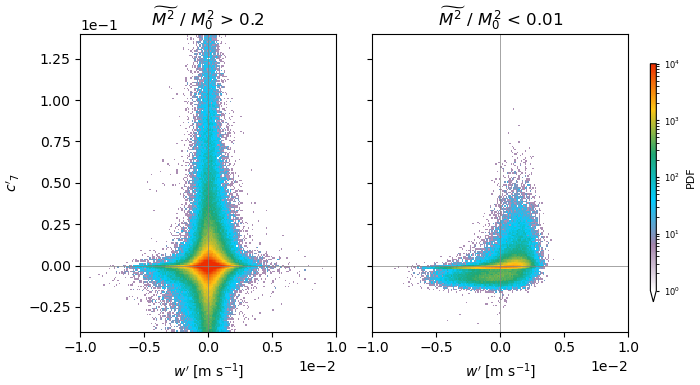

In [42]:
plt.close()
_,ax = plt.subplots(1,2, figsize=(7, 3.85), sharex=True, sharey=True, constrained_layout=True)

ax[0].pcolormesh(w_binc, c_binc, pdf_wcf.T, cmap=cmap_pdf, norm=mcolors.LogNorm(1, 1e4))
ax[0].axvline(0, c='gray', lw=0.5)
ax[0].axhline(0, c='gray', lw=0.5)
ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0, 0))
ax[0].set_title(r'$\widetilde{M^2}$ / $M_0^2$ > 0.2')
ax[0].set_ylabel(r"$c'_7$")
ax[0].set_xlabel(r"$w'$ [m s$^{-1}$]")

pcm = ax[1].pcolormesh(w_binc, c_binc, pdf_wcn.T, cmap=cmap_pdf, norm=mcolors.LogNorm(1, 1e4))
ax[1].axvline(0, c='gray', lw=0.5)
ax[1].axhline(0, c='gray', lw=0.5)
cbar = plt.colorbar(pcm, ax=ax[:], location='right', shrink=0.8, aspect=40, pad=0.02, extend='min')
cbar.ax.tick_params(labelsize=6, length=2)
cbar.set_label(label='PDF', size=8)

ax[1].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax[1].set_title(r'$\widetilde{M^2}$ / $M_0^2$ < 0.01')
ax[1].set_xlabel(r"$w'$ [m s$^{-1}$]");